In [1]:
import math
import random
from collections import defaultdict, Counter

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F  # For KL divergence in distillation
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

from Bio import SeqIO
import matplotlib.pyplot as plt  # For plotting

# Set device
device = (
    "cuda" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    "cpu"
)

###################################
# 1. Data Preparation Functions
###################################

def parse_fasta_with_labels(fasta_file):
    data = []
    for record in SeqIO.parse(fasta_file, "fasta"):
        header = record.description.strip()
        sequence = str(record.seq).upper()
        label = header.split()[0]
        data.append((label, sequence))
    return data

def create_train_test_split(raw_data):
    label_to_samples = defaultdict(list)
    for label, seq in raw_data:
        label_to_samples[label].append(seq)
    
    train_data = []
    test_data = []
    for label, seqs in label_to_samples.items():
        random.shuffle(seqs)
        test_seq = seqs[0]
        train_seqs = seqs[1:]
        test_data.append((label, test_seq))
        for s in train_seqs:
            train_data.append((label, s))
    return train_data, test_data

def generate_kmers(sequence, k=6):
    kmers = []
    for i in range(len(sequence) - k + 1):
        kmers.append(sequence[i:i+k])
    return kmers

def build_kmer_vocab(dataset, k=6):
    kmer_set = set()
    for _, seq in dataset:
        kmers = generate_kmers(seq, k)
        kmer_set.update(kmers)
    vocab = {"<UNK>": 0}
    for i, kmer in enumerate(sorted(kmer_set), start=1):
        vocab[kmer] = i
    return vocab

def encode_sequence(sequence, vocab, k=6):
    kmers = generate_kmers(sequence, k)
    encoded = [vocab.get(kmer, vocab["<UNK>"]) for kmer in kmers]
    return encoded

def filter_classes(raw_data, min_count=5):
    label_counts = Counter([label for (label, _) in raw_data])
    filtered_data = [(label, seq) for (label, seq) in raw_data if label_counts[label] >= min_count]
    return filtered_data

def reverse_complement(seq):
    # For simplicity, we just reverse the sequence.
    return seq[::-1]

def create_paired_data(data_list):
    paired = []
    for label, seq in data_list:
        rev_seq = reverse_complement(seq)
        paired.append((label, seq, rev_seq))
    return paired

class TwoFastaKmerDataset(Dataset):
    """
    Each item: (encoded_seq_fwd, encoded_seq_rev, label_idx)
    """
    def __init__(self, paired_data, vocab, k=6):
        super().__init__()
        self.vocab = vocab
        self.k = k
        labels = sorted(set(item[0] for item in paired_data))
        self.label2idx = {lbl: i for i, lbl in enumerate(labels)}
        self.encoded_data = []
        for label, fwd_seq, rev_seq in paired_data:
            x1 = encode_sequence(fwd_seq, self.vocab, k=self.k)
            x2 = encode_sequence(rev_seq, self.vocab, k=self.k)
            y = self.label2idx[label]
            self.encoded_data.append((x1, x2, y))
    
    def __len__(self):
        return len(self.encoded_data)
    
    def __getitem__(self, idx):
        return self.encoded_data[idx]
    
    def get_vocab_size(self):
        return len(self.vocab)
    
    def get_num_classes(self):
        return len(self.label2idx)

def collate_fn_two(batch):
    seqs_fwd, seqs_rev, labels = zip(*batch)
    seqs_fwd_tensors = [torch.tensor(s, dtype=torch.long) for s in seqs_fwd]
    seqs_rev_tensors = [torch.tensor(s, dtype=torch.long) for s in seqs_rev]
    padded_fwd = pad_sequence(seqs_fwd_tensors, batch_first=True, padding_value=0)
    padded_rev = pad_sequence(seqs_rev_tensors, batch_first=True, padding_value=0)
    labels_tensors = torch.tensor(labels, dtype=torch.long)
    return padded_fwd, padded_rev, labels_tensors

###################################
# 2. Model Architecture
###################################

class ViTDeepSEAEncoder(nn.Module):
    """
    This module performs:
      1. k-mer embedding.
      2. A DeepSEA-style convolutional block.
      3. Batch normalization on the conv output.
      4. A linear projection to d_model.
      5. Addition of positional embeddings.
      6. Transformer encoding over the tokens.
      7. Mean pooling over tokens to produce a fixed-length vector.
    """
    def __init__(
        self,
        vocab_size,
        embed_dim=128,
        d_model=256,  # Output feature dimension
        num_conv_filters=(320, 480, 960),
        conv_kernel_sizes=(8, 8, 8),
        pool_kernel_sizes=(4, 4),
        num_transformer_layers=2,
        nhead=8,
        dropout=0.1,
        max_seq_len=1000
    ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.deepsea_conv = nn.Sequential(
            nn.Conv1d(in_channels=embed_dim, out_channels=num_conv_filters[0], kernel_size=conv_kernel_sizes[0]),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=pool_kernel_sizes[0]),
            nn.Conv1d(in_channels=num_conv_filters[0], out_channels=num_conv_filters[1], kernel_size=conv_kernel_sizes[1]),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=pool_kernel_sizes[1]),
            nn.Conv1d(in_channels=num_conv_filters[1], out_channels=num_conv_filters[2], kernel_size=conv_kernel_sizes[2]),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        self.bn = nn.BatchNorm1d(num_conv_filters[2])
        self.proj = nn.Linear(num_conv_filters[2], d_model)
        self.max_tokens = 150  # Maximum tokens after conv+pooling
        self.pos_embedding = nn.Parameter(torch.zeros(1, self.max_tokens, d_model))
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_transformer_layers)
    
    def forward(self, x):
        # x: [B, seq_len]
        x = self.embedding(x)            # [B, seq_len, embed_dim]
        x = x.transpose(1, 2)            # [B, embed_dim, seq_len] for Conv1d
        x = self.deepsea_conv(x)         # [B, num_conv_filters[-1], L_out]
        x = self.bn(x)                   # Apply batch normalization
        x = x.transpose(1, 2)            # [B, L_out, num_conv_filters[-1]]
        x = self.proj(x)                 # [B, L_out, d_model]
        B, L, _ = x.size()
        pos_embed = self.pos_embedding[:, :L, :]
        x = x + pos_embed
        x = self.transformer_encoder(x)  # [B, L, d_model]
        x = x.mean(dim=1)                # [B, d_model]
        return x

class TwoViTDeepSEAFusionDNAClassifierWithFC(nn.Module):
    """
    Two-branch model: each branch processes one sequence (forward and reverse).
    The outputs (each d_model-dimensional) are concatenated and fed to an FC layer.
    """
    def __init__(
        self,
        vocab_size,
        num_classes,
        embed_dim=128,
        d_model=256,  # Each branch outputs d_model features (256)
        num_conv_filters=(320, 480, 960),
        conv_kernel_sizes=(8, 8, 8),
        pool_kernel_sizes=(4, 4),
        num_transformer_layers=2,
        nhead=8,
        dropout=0.1,
        max_seq_len=1000
    ):
        super().__init__()
        self.vit_branch1 = ViTDeepSEAEncoder(
            vocab_size=vocab_size,
            embed_dim=embed_dim,
            d_model=d_model,
            num_conv_filters=num_conv_filters,
            conv_kernel_sizes=conv_kernel_sizes,
            pool_kernel_sizes=pool_kernel_sizes,
            num_transformer_layers=num_transformer_layers,
            nhead=nhead,
            dropout=dropout,
            max_seq_len=max_seq_len
        )
        self.vit_branch2 = ViTDeepSEAEncoder(
            vocab_size=vocab_size,
            embed_dim=embed_dim,
            d_model=d_model,
            num_conv_filters=num_conv_filters,
            conv_kernel_sizes=conv_kernel_sizes,
            pool_kernel_sizes=pool_kernel_sizes,
            num_transformer_layers=num_transformer_layers,
            nhead=nhead,
            dropout=dropout,
            max_seq_len=max_seq_len
        )
        self.fc = nn.Linear(2 * d_model, num_classes)
    
    def forward(self, x1, x2):
        f1 = self.vit_branch1(x1)  # [B, d_model]
        f2 = self.vit_branch2(x2)  # [B, d_model]
        fused = torch.cat([f1, f2], dim=1)  # [B, 2*d_model]
        logits = self.fc(fused)             # [B, num_classes]
        return logits

###################################
# 3. Build Vocabulary from the Entire Dataset
###################################
fasta_file = "data2/fungi_ITS_cleaned.fasta"
raw_data = parse_fasta_with_labels(fasta_file)
vocab = build_kmer_vocab(raw_data, k=6)

###################################
# 4. Teacher Training (for genera with >10 samples)
###################################
teacher_data = filter_classes(raw_data, min_count=10)
teacher_train_data, teacher_test_data = create_train_test_split(teacher_data)
teacher_paired_train = create_paired_data(teacher_train_data)
teacher_paired_test = create_paired_data(teacher_test_data)
teacher_dataset = TwoFastaKmerDataset(teacher_paired_train, vocab, k=6)
teacher_test_dataset = TwoFastaKmerDataset(teacher_paired_test, vocab, k=6)

teacher_train_loader = DataLoader(teacher_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn_two)
teacher_test_loader = DataLoader(teacher_test_dataset, batch_size=8, shuffle=False, collate_fn=collate_fn_two)

num_classes_teacher = teacher_dataset.get_num_classes()
vocab_size = teacher_dataset.get_vocab_size()

teacher_model = TwoViTDeepSEAFusionDNAClassifierWithFC(
    vocab_size=vocab_size,
    num_classes=num_classes_teacher,
    embed_dim=128,
    d_model=256,
    num_conv_filters=(320, 480, 960),
    conv_kernel_sizes=(8, 8, 8),
    pool_kernel_sizes=(4, 4),
    num_transformer_layers=2,
    nhead=8,
    dropout=0.1,
    max_seq_len=1000
).to(device)

optimizer_teacher = optim.AdamW(teacher_model.parameters(), lr=1e-4, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

teacher_epochs = 100
best_teacher_acc = 0.0
best_teacher_state = None

print("Starting teacher training...")
for epoch in range(1, teacher_epochs + 1):
    teacher_model.train()
    total_loss = 0.0
    for fwd, rev, labels in teacher_train_loader:
        fwd, rev, labels = fwd.to(device), rev.to(device), labels.to(device)
        optimizer_teacher.zero_grad()
        logits = teacher_model(fwd, rev)
        loss = criterion(logits, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(teacher_model.parameters(), max_norm=1.0)
        optimizer_teacher.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(teacher_train_loader)
    
    teacher_model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for fwd, rev, labels in teacher_test_loader:
            fwd, rev, labels = fwd.to(device), rev.to(device), labels.to(device)
            preds = torch.argmax(teacher_model(fwd, rev), dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    teacher_test_acc = 100.0 * correct / total
    print(f"[Teacher] Epoch {epoch}/{teacher_epochs} | Loss: {avg_loss:.4f} | Test Acc: {teacher_test_acc:.2f}%")
    
    # Save best teacher state
    if teacher_test_acc > best_teacher_acc:
        best_teacher_acc = teacher_test_acc
        best_teacher_state = teacher_model.state_dict()

# Load the best teacher checkpoint
teacher_model.load_state_dict(best_teacher_state)
# Freeze teacher parameters
for param in teacher_model.parameters():
    param.requires_grad = False
teacher_model.eval()
print(f"Best Teacher Accuracy: {best_teacher_acc:.2f}%")

###################################
# 5. Student Training with Knowledge Distillation
#    (Student data: classes with >=8 samples, restricted to teacher classes)
###################################
student_data = filter_classes(raw_data, min_count=8)
teacher_class_set = set(teacher_dataset.label2idx.keys())
student_data = [(label, seq) for (label, seq) in student_data if label in teacher_class_set]

student_train_data, student_test_data = create_train_test_split(student_data)
student_paired_train = create_paired_data(student_train_data)
student_paired_test = create_paired_data(student_test_data)
student_dataset = TwoFastaKmerDataset(student_paired_train, vocab, k=6)
student_test_dataset = TwoFastaKmerDataset(student_paired_test, vocab, k=6)

student_train_loader = DataLoader(student_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn_two)
student_test_loader = DataLoader(student_test_dataset, batch_size=8, shuffle=False, collate_fn=collate_fn_two)

num_classes_student = student_dataset.get_num_classes()

student_model = TwoViTDeepSEAFusionDNAClassifierWithFC(
    vocab_size=vocab_size,
    num_classes=num_classes_student,
    embed_dim=128,
    d_model=256,
    num_conv_filters=(320, 480, 960),
    conv_kernel_sizes=(8, 8, 8),
    pool_kernel_sizes=(4, 4),
    num_transformer_layers=2,
    nhead=8,
    dropout=0.1,
    max_seq_len=1000
).to(device)

optimizer_student = optim.AdamW(student_model.parameters(), lr=1e-4, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

# Distillation hyperparameters:
temperature = 4.0  # Temperature for softening probabilities
alpha = 0.5        # Weight for the distillation loss

def distillation_loss(student_logits, teacher_logits, T):
    return F.kl_div(F.log_softmax(student_logits / T, dim=1),
                    F.softmax(teacher_logits / T, dim=1),
                    reduction="batchmean") * (T * T)

student_epochs = 100
best_student_test_acc = 0.0
best_student_epoch = 0
student_acc_list = []

print("\nStarting student training with distillation...")
for epoch in range(1, student_epochs + 1):
    student_model.train()
    total_loss = 0.0
    for fwd, rev, labels in student_train_loader:
        fwd, rev, labels = fwd.to(device), rev.to(device), labels.to(device)
        optimizer_student.zero_grad()
        student_logits = student_model(fwd, rev)
        with torch.no_grad():
            teacher_logits = teacher_model(fwd, rev)
        ce_loss = criterion(student_logits, labels)
        kd_loss = distillation_loss(student_logits, teacher_logits, temperature)
        loss = alpha * kd_loss + (1 - alpha) * ce_loss
        loss.backward()
        torch.nn.utils.clip_grad_norm_(student_model.parameters(), max_norm=1.0)
        optimizer_student.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(student_train_loader)
    
    student_model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for fwd, rev, labels in student_test_loader:
            fwd, rev, labels = fwd.to(device), rev.to(device), labels.to(device)
            preds = torch.argmax(student_model(fwd, rev), dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    student_test_acc = 100.0 * correct / total
    student_acc_list.append(student_test_acc)
    
    if student_test_acc > best_student_test_acc:
        best_student_test_acc = student_test_acc
        best_student_epoch = epoch
    
    print(f"[Student] Epoch {epoch}/{student_epochs} | Loss: {avg_loss:.4f} | Test Acc: {student_test_acc:.2f}%")

print(f"\nHighest Student Test Accuracy: {best_student_test_acc:.2f}% at Epoch {best_student_epoch}")

# Plot student test accuracy over epochs (optional)
epochs_range = range(1, student_epochs + 1)
plt.figure(figsize=(8, 5))
plt.plot(epochs_range, student_acc_list, marker="o", label="Student Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Student Test Accuracy Over Epochs (with Knowledge Distillation)")
plt.legend()
plt.show()


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Starting teacher training...
[Teacher] Epoch 1/100 | Loss: 3.3195 | Test Acc: 7.41%
[Teacher] Epoch 2/100 | Loss: 1.7554 | Test Acc: 7.41%
[Teacher] Epoch 3/100 | Loss: 0.8949 | Test Acc: 30.86%
[Teacher] Epoch 4/100 | Loss: 0.4029 | Test Acc: 13.58%
[Teacher] Epoch 5/100 | Loss: 0.1740 | Test Acc: 20.99%
[Teacher] Epoch 6/100 | Loss: 0.0776 | Test Acc: 22.22%
[Teacher] Epoch 7/100 | Loss: 0.0289 | Test Acc: 19.75%
[Teacher] Epoch 8/100 | Loss: 0.0151 | Test Acc: 45.68%


KeyboardInterrupt: 

C:\Users\user\AppData\Roaming\Python\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Starting teacher training (min_count >= 10)...
[Teacher] Epoch 1/100 | Loss: 3.3002 | Test Acc: 7.41%
[Teacher] Epoch 2/100 | Loss: 1.7817 | Test Acc: 14.81%
[Teacher] Epoch 3/100 | Loss: 0.8600 | Test Acc: 22.22%
[Teacher] Epoch 4/100 | Loss: 0.3555 | Test Acc: 17.28%
[Teacher] Epoch 5/100 | Loss: 0.1507 | Test Acc: 28.40%
[Teacher] Epoch 6/100 | Loss: 0.0524 | Test Acc: 23.46%
[Teacher] Epoch 7/100 | Loss: 0.0242 | Test Acc: 27.16%
[Teacher] Epoch 8/100 | Loss: 0.0101 | Test Acc: 76.54%
[Teacher] Epoch 9/100 | Loss: 0.0045 | Test Acc: 92.59%
[Teacher] Epoch 10/100 | Loss: 0.0033 | Test Acc: 55.56%
[Teacher] Epoch 11/100 | Loss: 0.0018 | Test Acc: 97.53%
[Teacher] Epoch 12/100 | Loss: 0.0012 | Test Acc: 95.06%
[Teacher] Epoch 13/100 | Loss: 0.0017 | Test Acc: 100.00%
[Teacher] Epoch 14/100 | Loss: 0.0009 | Test Acc: 98.77%
[Teacher] Epoch 15/100 | Loss: 0.0007 | Test Acc: 85.19%
[Teacher] Epoch 16/100 | Loss: 0.0005 | Test Acc: 98.77%
[Teacher] Epoch 17/100 | Loss: 0.0005 | Test Acc: 

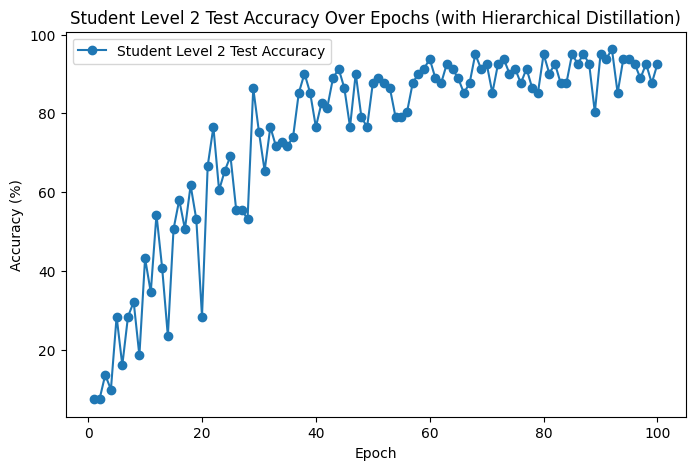

In [ ]:
import math
import random
from collections import defaultdict, Counter

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F  # For KL divergence in distillation
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

from Bio import SeqIO
import matplotlib.pyplot as plt  # For plotting

# Set device
device = (
    "cuda" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    "cpu"
)

###################################
# 1. Data Preparation Functions
###################################

def parse_fasta_with_labels(fasta_file):
    data = []
    for record in SeqIO.parse(fasta_file, "fasta"):
        header = record.description.strip()
        sequence = str(record.seq).upper()
        label = header.split()[0]
        data.append((label, sequence))
    return data

def create_train_test_split(raw_data):
    label_to_samples = defaultdict(list)
    for label, seq in raw_data:
        label_to_samples[label].append(seq)
    
    train_data = []
    test_data = []
    for label, seqs in label_to_samples.items():
        random.shuffle(seqs)
        test_seq = seqs[0]
        train_seqs = seqs[1:]
        test_data.append((label, test_seq))
        for s in train_seqs:
            train_data.append((label, s))
    return train_data, test_data

def generate_kmers(sequence, k=6):
    kmers = []
    for i in range(len(sequence) - k + 1):
        kmers.append(sequence[i:i+k])
    return kmers

def build_kmer_vocab(dataset, k=6):
    kmer_set = set()
    for _, seq in dataset:
        kmers = generate_kmers(seq, k)
        kmer_set.update(kmers)
    vocab = {"<UNK>": 0}
    for i, kmer in enumerate(sorted(kmer_set), start=1):
        vocab[kmer] = i
    return vocab

def encode_sequence(sequence, vocab, k=6):
    kmers = generate_kmers(sequence, k)
    encoded = [vocab.get(kmer, vocab["<UNK>"]) for kmer in kmers]
    return encoded

def filter_classes(raw_data, min_count=5):
    label_counts = Counter([label for (label, _) in raw_data])
    filtered_data = [(label, seq) for (label, seq) in raw_data if label_counts[label] >= min_count]
    return filtered_data

def reverse_complement(seq):
    # For simplicity, we just reverse the sequence.
    return seq[::-1]

def create_paired_data(data_list):
    paired = []
    for label, seq in data_list:
        rev_seq = reverse_complement(seq)
        paired.append((label, seq, rev_seq))
    return paired

class TwoFastaKmerDataset(Dataset):
    """
    Each item: (encoded_seq_fwd, encoded_seq_rev, label_idx)
    """
    def __init__(self, paired_data, vocab, k=6):
        super().__init__()
        self.vocab = vocab
        self.k = k
        labels = sorted(set(item[0] for item in paired_data))
        self.label2idx = {lbl: i for i, lbl in enumerate(labels)}
        self.encoded_data = []
        for label, fwd_seq, rev_seq in paired_data:
            x1 = encode_sequence(fwd_seq, self.vocab, k=self.k)
            x2 = encode_sequence(rev_seq, self.vocab, k=self.k)
            y = self.label2idx[label]
            self.encoded_data.append((x1, x2, y))
    
    def __len__(self):
        return len(self.encoded_data)
    
    def __getitem__(self, idx):
        return self.encoded_data[idx]
    
    def get_vocab_size(self):
        return len(self.vocab)
    
    def get_num_classes(self):
        return len(self.label2idx)

def collate_fn_two(batch):
    seqs_fwd, seqs_rev, labels = zip(*batch)
    seqs_fwd_tensors = [torch.tensor(s, dtype=torch.long) for s in seqs_fwd]
    seqs_rev_tensors = [torch.tensor(s, dtype=torch.long) for s in seqs_rev]
    padded_fwd = pad_sequence(seqs_fwd_tensors, batch_first=True, padding_value=0)
    padded_rev = pad_sequence(seqs_rev_tensors, batch_first=True, padding_value=0)
    labels_tensors = torch.tensor(labels, dtype=torch.long)
    return padded_fwd, padded_rev, labels_tensors

###################################
# 2. Model Architecture
###################################

class ViTDeepSEAEncoder(nn.Module):
    """
    This module performs:
      1. k-mer embedding.
      2. A DeepSEA-style convolutional block.
      3. Batch normalization on the conv output.
      4. A linear projection to d_model.
      5. Addition of positional embeddings.
      6. Transformer encoding over the tokens.
      7. Mean pooling over tokens to produce a fixed-length vector.
    """
    def __init__(
        self,
        vocab_size,
        embed_dim=128,
        d_model=256,  # Output feature dimension
        num_conv_filters=(320, 480, 960),
        conv_kernel_sizes=(8, 8, 8),
        pool_kernel_sizes=(4, 4),
        num_transformer_layers=2,
        nhead=8,
        dropout=0.1,
        max_seq_len=1000
    ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.deepsea_conv = nn.Sequential(
            nn.Conv1d(in_channels=embed_dim, out_channels=num_conv_filters[0], kernel_size=conv_kernel_sizes[0]),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=pool_kernel_sizes[0]),
            nn.Conv1d(in_channels=num_conv_filters[0], out_channels=num_conv_filters[1], kernel_size=conv_kernel_sizes[1]),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=pool_kernel_sizes[1]),
            nn.Conv1d(in_channels=num_conv_filters[1], out_channels=num_conv_filters[2], kernel_size=conv_kernel_sizes[2]),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        self.bn = nn.BatchNorm1d(num_conv_filters[2])
        self.proj = nn.Linear(num_conv_filters[2], d_model)
        self.max_tokens = 150  # Maximum tokens after conv+pooling
        self.pos_embedding = nn.Parameter(torch.zeros(1, self.max_tokens, d_model))
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_transformer_layers)
    
    def forward(self, x):
        # x: [B, seq_len]
        x = self.embedding(x)            # [B, seq_len, embed_dim]
        x = x.transpose(1, 2)            # [B, embed_dim, seq_len]
        x = self.deepsea_conv(x)         # [B, num_conv_filters[-1], L_out]
        x = self.bn(x)                   # Batch normalization
        x = x.transpose(1, 2)            # [B, L_out, num_conv_filters[-1]]
        x = self.proj(x)                 # [B, L_out, d_model]
        B, L, _ = x.size()
        pos_embed = self.pos_embedding[:, :L, :]
        x = x + pos_embed
        x = self.transformer_encoder(x)  # [B, L, d_model]
        x = x.mean(dim=1)                # [B, d_model]
        return x

class TwoViTDeepSEAFusionDNAClassifierWithFC(nn.Module):
    """
    Two-branch model: each branch processes one sequence (forward and reverse).
    Their outputs are concatenated and passed through a fully-connected layer.
    """
    def __init__(
        self,
        vocab_size,
        num_classes,
        embed_dim=128,
        d_model=256,
        num_conv_filters=(320, 480, 960),
        conv_kernel_sizes=(8, 8, 8),
        pool_kernel_sizes=(4, 4),
        num_transformer_layers=2,
        nhead=8,
        dropout=0.1,
        max_seq_len=1000
    ):
        super().__init__()
        self.vit_branch1 = ViTDeepSEAEncoder(
            vocab_size=vocab_size,
            embed_dim=embed_dim,
            d_model=d_model,
            num_conv_filters=num_conv_filters,
            conv_kernel_sizes=conv_kernel_sizes,
            pool_kernel_sizes=pool_kernel_sizes,
            num_transformer_layers=num_transformer_layers,
            nhead=nhead,
            dropout=dropout,
            max_seq_len=max_seq_len
        )
        self.vit_branch2 = ViTDeepSEAEncoder(
            vocab_size=vocab_size,
            embed_dim=embed_dim,
            d_model=d_model,
            num_conv_filters=num_conv_filters,
            conv_kernel_sizes=conv_kernel_sizes,
            pool_kernel_sizes=pool_kernel_sizes,
            num_transformer_layers=num_transformer_layers,
            nhead=nhead,
            dropout=dropout,
            max_seq_len=max_seq_len
        )
        self.fc = nn.Linear(2 * d_model, num_classes)
    
    def forward(self, x1, x2):
        f1 = self.vit_branch1(x1)  # [B, d_model]
        f2 = self.vit_branch2(x2)  # [B, d_model]
        fused = torch.cat([f1, f2], dim=1)  # [B, 2*d_model]
        logits = self.fc(fused)             # [B, num_classes]
        return logits

###################################
# 3. Build Vocabulary from the Entire Dataset
###################################
fasta_file = "data2/fungi_ITS_cleaned.fasta"
raw_data = parse_fasta_with_labels(fasta_file)
vocab = build_kmer_vocab(raw_data, k=6)

###################################
# Stage 1: Teacher Training (for genera with >10 samples)
###################################
teacher_data = filter_classes(raw_data, min_count=10)
teacher_train_data, teacher_test_data = create_train_test_split(teacher_data)
teacher_paired_train = create_paired_data(teacher_train_data)
teacher_paired_test = create_paired_data(teacher_test_data)
teacher_dataset = TwoFastaKmerDataset(teacher_paired_train, vocab, k=6)
teacher_test_dataset = TwoFastaKmerDataset(teacher_paired_test, vocab, k=6)

teacher_train_loader = DataLoader(teacher_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn_two)
teacher_test_loader = DataLoader(teacher_test_dataset, batch_size=8, shuffle=False, collate_fn=collate_fn_two)

num_classes_teacher = teacher_dataset.get_num_classes()
vocab_size = teacher_dataset.get_vocab_size()

teacher_model = TwoViTDeepSEAFusionDNAClassifierWithFC(
    vocab_size=vocab_size,
    num_classes=num_classes_teacher,
    embed_dim=128,
    d_model=256,
    num_conv_filters=(320, 480, 960),
    conv_kernel_sizes=(8,8,8),
    pool_kernel_sizes=(4,4),
    num_transformer_layers=2,
    nhead=8,
    dropout=0.1,
    max_seq_len=1000
).to(device)

optimizer_teacher = optim.AdamW(teacher_model.parameters(), lr=1e-4, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

teacher_epochs = 100
best_teacher_acc = 0.0
best_teacher_state = None

print("Starting teacher training (min_count >= 10)...")
for epoch in range(1, teacher_epochs + 1):
    teacher_model.train()
    total_loss = 0.0
    for fwd, rev, labels in teacher_train_loader:
        fwd, rev, labels = fwd.to(device), rev.to(device), labels.to(device)
        optimizer_teacher.zero_grad()
        logits = teacher_model(fwd, rev)
        loss = criterion(logits, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(teacher_model.parameters(), max_norm=1.0)
        optimizer_teacher.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(teacher_train_loader)
    
    teacher_model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for fwd, rev, labels in teacher_test_loader:
            fwd, rev, labels = fwd.to(device), rev.to(device), labels.to(device)
            preds = torch.argmax(teacher_model(fwd, rev), dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    teacher_test_acc = 100.0 * correct / total
    print(f"[Teacher] Epoch {epoch}/{teacher_epochs} | Loss: {avg_loss:.4f} | Test Acc: {teacher_test_acc:.2f}%")
    
    if teacher_test_acc > best_teacher_acc:
        best_teacher_acc = teacher_test_acc
        best_teacher_state = teacher_model.state_dict()

# Load best teacher checkpoint and freeze parameters.
teacher_model.load_state_dict(best_teacher_state)
for param in teacher_model.parameters():
    param.requires_grad = False
teacher_model.eval()
print(f"Best Teacher Accuracy: {best_teacher_acc:.2f}%")

###################################
# Stage 2: Student Level 1 Training with Knowledge Distillation (min_count >= 8)
###################################
# Filter student data: classes with >=8 samples and restrict to teacher classes.
student8_data = filter_classes(raw_data, min_count=8)
teacher_class_set = set(teacher_dataset.label2idx.keys())
student8_data = [(label, seq) for (label, seq) in student8_data if label in teacher_class_set]

student8_train_data, student8_test_data = create_train_test_split(student8_data)
student8_paired_train = create_paired_data(student8_train_data)
student8_paired_test = create_paired_data(student8_test_data)
student8_dataset = TwoFastaKmerDataset(student8_paired_train, vocab, k=6)
student8_test_dataset = TwoFastaKmerDataset(student8_paired_test, vocab, k=6)

student8_train_loader = DataLoader(student8_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn_two)
student8_test_loader = DataLoader(student8_test_dataset, batch_size=8, shuffle=False, collate_fn=collate_fn_two)

num_classes_student8 = student8_dataset.get_num_classes()

student8_model = TwoViTDeepSEAFusionDNAClassifierWithFC(
    vocab_size=vocab_size,
    num_classes=num_classes_student8,
    embed_dim=128,
    d_model=256,
    num_conv_filters=(320,480,960),
    conv_kernel_sizes=(8,8,8),
    pool_kernel_sizes=(4,4),
    num_transformer_layers=2,
    nhead=8,
    dropout=0.1,
    max_seq_len=1000
).to(device)

optimizer_student8 = optim.AdamW(student8_model.parameters(), lr=1e-4, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

# Distillation hyperparameters for stage 2:
temperature = 4.0
alpha = 0.5

def distillation_loss(student_logits, teacher_logits, T):
    return F.kl_div(F.log_softmax(student_logits / T, dim=1),
                    F.softmax(teacher_logits / T, dim=1),
                    reduction="batchmean") * (T * T)

student8_epochs = 100
best_student8_acc = 0.0
best_student8_epoch = 0
student8_acc_list = []

print("\nStarting Student Level 1 training (min_count >= 8) with distillation from Teacher...")
for epoch in range(1, student8_epochs + 1):
    student8_model.train()
    total_loss = 0.0
    for fwd, rev, labels in student8_train_loader:
        fwd, rev, labels = fwd.to(device), rev.to(device), labels.to(device)
        optimizer_student8.zero_grad()
        student_logits = student8_model(fwd, rev)
        with torch.no_grad():
            teacher_logits = teacher_model(fwd, rev)
        ce_loss = criterion(student_logits, labels)
        kd_loss = distillation_loss(student_logits, teacher_logits, temperature)
        loss = alpha * kd_loss + (1 - alpha) * ce_loss
        loss.backward()
        torch.nn.utils.clip_grad_norm_(student8_model.parameters(), max_norm=1.0)
        optimizer_student8.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(student8_train_loader)
    
    student8_model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for fwd, rev, labels in student8_test_loader:
            fwd, rev, labels = fwd.to(device), rev.to(device), labels.to(device)
            preds = torch.argmax(student8_model(fwd, rev), dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    student8_test_acc = 100.0 * correct / total
    student8_acc_list.append(student8_test_acc)
    
    if student8_test_acc > best_student8_acc:
        best_student8_acc = student8_test_acc
        best_student8_epoch = epoch
        best_student8_state = student8_model.state_dict()
    
    print(f"[Student Level 1] Epoch {epoch}/{student8_epochs} | Loss: {avg_loss:.4f} | Test Acc: {student8_test_acc:.2f}%")

print(f"\nHighest Student Level 1 Test Accuracy: {best_student8_acc:.2f}% at Epoch {best_student8_epoch}")

# Load best Student Level 1 checkpoint and freeze parameters.
student8_model.load_state_dict(best_student8_state)
for param in student8_model.parameters():
    param.requires_grad = False
student8_model.eval()

###################################
# Stage 3: Student Level 2 Training with Knowledge Distillation (min_count >= 5)
###################################
# Now, use the Student Level 1 as the teacher for Student Level 2.
# Filter student data: classes with >=5 samples and restrict to classes present in Student Level 1.
student5_data = filter_classes(raw_data, min_count=5)
student5_data = [(label, seq) for (label, seq) in student5_data if label in set(student8_dataset.label2idx.keys())]

student5_train_data, student5_test_data = create_train_test_split(student5_data)
student5_paired_train = create_paired_data(student5_train_data)
student5_paired_test = create_paired_data(student5_test_data)
student5_dataset = TwoFastaKmerDataset(student5_paired_train, vocab, k=6)
student5_test_dataset = TwoFastaKmerDataset(student5_paired_test, vocab, k=6)

student5_train_loader = DataLoader(student5_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn_two)
student5_test_loader = DataLoader(student5_test_dataset, batch_size=8, shuffle=False, collate_fn=collate_fn_two)

num_classes_student5 = student5_dataset.get_num_classes()

student5_model = TwoViTDeepSEAFusionDNAClassifierWithFC(
    vocab_size=vocab_size,
    num_classes=num_classes_student5,
    embed_dim=128,
    d_model=256,
    num_conv_filters=(320,480,960),
    conv_kernel_sizes=(8,8,8),
    pool_kernel_sizes=(4,4),
    num_transformer_layers=2,
    nhead=8,
    dropout=0.1,
    max_seq_len=1000
).to(device)

optimizer_student5 = optim.AdamW(student5_model.parameters(), lr=1e-4, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

# Use same distillation hyperparameters:
temperature = 4.0
alpha = 0.5

student5_epochs = 100
best_student5_acc = 0.0
best_student5_epoch = 0
student5_acc_list = []

print("\nStarting Student Level 2 training (min_count >= 5) with distillation from Student Level 1...")
for epoch in range(1, student5_epochs + 1):
    student5_model.train()
    total_loss = 0.0
    for fwd, rev, labels in student5_train_loader:
        fwd, rev, labels = fwd.to(device), rev.to(device), labels.to(device)
        optimizer_student5.zero_grad()
        student_logits = student5_model(fwd, rev)
        with torch.no_grad():
            teacher_logits = student8_model(fwd, rev)
        ce_loss = criterion(student_logits, labels)
        kd_loss = distillation_loss(student_logits, teacher_logits, temperature)
        loss = alpha * kd_loss + (1 - alpha) * ce_loss
        loss.backward()
        torch.nn.utils.clip_grad_norm_(student5_model.parameters(), max_norm=1.0)
        optimizer_student5.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(student5_train_loader)
    
    student5_model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for fwd, rev, labels in student5_test_loader:
            fwd, rev, labels = fwd.to(device), rev.to(device), labels.to(device)
            preds = torch.argmax(student5_model(fwd, rev), dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    student5_test_acc = 100.0 * correct / total
    student5_acc_list.append(student5_test_acc)
    
    if student5_test_acc > best_student5_acc:
        best_student5_acc = student5_test_acc
        best_student5_epoch = epoch
    
    print(f"[Student Level 2] Epoch {epoch}/{student5_epochs} | Loss: {avg_loss:.4f} | Test Acc: {student5_test_acc:.2f}%")

print(f"\nHighest Student Level 2 Test Accuracy: {best_student5_acc:.2f}% at Epoch {best_student5_epoch}")

# Optionally, plot Student Level 2 test accuracy over epochs.
epochs_range = range(1, student5_epochs + 1)
plt.figure(figsize=(8, 5))
plt.plot(epochs_range, student5_acc_list, marker="o", label="Student Level 2 Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Student Level 2 Test Accuracy Over Epochs (with Hierarchical Distillation)")
plt.legend()
plt.show()


Starting teacher training (min_count >= 10) with early stopping...
[Teacher] Epoch 1/100 | Loss: 3.3346 | Train Acc: 14.52% | Test Acc: 1.23%
[Teacher] Epoch 2/100 | Loss: 1.8727 | Train Acc: 43.98% | Test Acc: 20.99%
[Teacher] Epoch 3/100 | Loss: 0.9330 | Train Acc: 34.43% | Test Acc: 16.05%
[Teacher] Epoch 4/100 | Loss: 0.4237 | Train Acc: 63.65% | Test Acc: 28.40%
[Teacher] Epoch 5/100 | Loss: 0.1824 | Train Acc: 64.76% | Test Acc: 29.63%
[Teacher] Epoch 6/100 | Loss: 0.0746 | Train Acc: 49.63% | Test Acc: 33.33%
[Teacher] Epoch 7/100 | Loss: 0.0320 | Train Acc: 63.28% | Test Acc: 40.74%
[Teacher] Epoch 8/100 | Loss: 0.0104 | Train Acc: 99.88% | Test Acc: 81.48%
[Teacher] Epoch 9/100 | Loss: 0.0056 | Train Acc: 99.13% | Test Acc: 70.37%
[Teacher] Epoch 10/100 | Loss: 0.0037 | Train Acc: 99.44% | Test Acc: 64.20%
[Teacher] Epoch 11/100 | Loss: 0.0021 | Train Acc: 100.00% | Test Acc: 95.06%
[Teacher] Epoch 12/100 | Loss: 0.0013 | Train Acc: 100.00% | Test Acc: 95.06%
[Teacher] Epoch 1

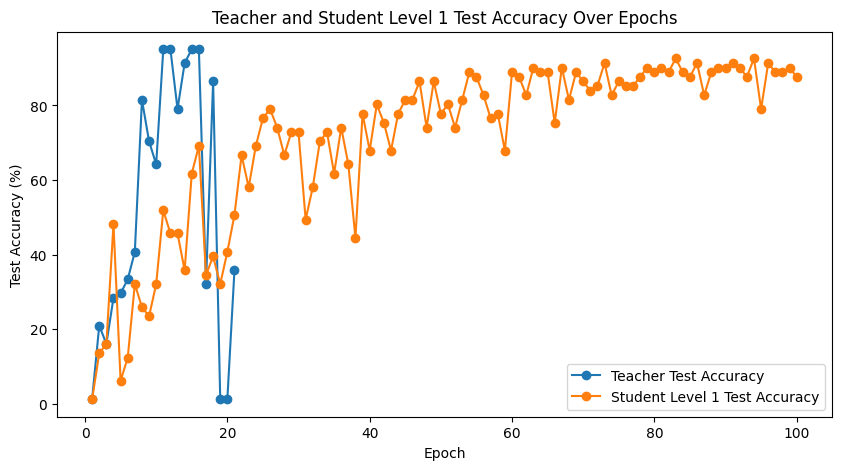

In [ ]:
import math
import random
from collections import defaultdict, Counter

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F  # For KL divergence in distillation
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

from Bio import SeqIO
import matplotlib.pyplot as plt  # For plotting

# Set device
device = (
    "cuda" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    "cpu"
)

###################################
# 1. Data Preparation Functions
###################################

def parse_fasta_with_labels(fasta_file):
    data = []
    for record in SeqIO.parse(fasta_file, "fasta"):
        header = record.description.strip()
        sequence = str(record.seq).upper()
        label = header.split()[0]
        data.append((label, sequence))
    return data

def create_train_test_split(raw_data):
    label_to_samples = defaultdict(list)
    for label, seq in raw_data:
        label_to_samples[label].append(seq)
    train_data = []
    test_data = []
    for label, seqs in label_to_samples.items():
        random.shuffle(seqs)
        test_seq = seqs[0]
        train_seqs = seqs[1:]
        test_data.append((label, test_seq))
        for s in train_seqs:
            train_data.append((label, s))
    return train_data, test_data

def generate_kmers(sequence, k=6):
    kmers = []
    for i in range(len(sequence) - k + 1):
        kmers.append(sequence[i:i+k])
    return kmers

def build_kmer_vocab(dataset, k=6):
    kmer_set = set()
    for _, seq in dataset:
        kmers = generate_kmers(seq, k)
        kmer_set.update(kmers)
    vocab = {"<UNK>": 0}
    for i, kmer in enumerate(sorted(kmer_set), start=1):
        vocab[kmer] = i
    return vocab

def encode_sequence(sequence, vocab, k=6):
    kmers = generate_kmers(sequence, k)
    encoded = [vocab.get(kmer, vocab["<UNK>"]) for kmer in kmers]
    return encoded

def filter_classes(raw_data, min_count=5):
    label_counts = Counter([label for (label, _) in raw_data])
    filtered_data = [(label, seq) for (label, seq) in raw_data if label_counts[label] >= min_count]
    return filtered_data

def reverse_complement(seq):
    # For simplicity, we just reverse the sequence.
    return seq[::-1]

def create_paired_data(data_list):
    paired = []
    for label, seq in data_list:
        rev_seq = reverse_complement(seq)
        paired.append((label, seq, rev_seq))
    return paired

class TwoFastaKmerDataset(Dataset):
    """
    Each item: (encoded_seq_fwd, encoded_seq_rev, label_idx)
    """
    def __init__(self, paired_data, vocab, k=6):
        super().__init__()
        self.vocab = vocab
        self.k = k
        labels = sorted(set(item[0] for item in paired_data))
        self.label2idx = {lbl: i for i, lbl in enumerate(labels)}
        self.encoded_data = []
        for label, fwd_seq, rev_seq in paired_data:
            x1 = encode_sequence(fwd_seq, self.vocab, k=self.k)
            x2 = encode_sequence(rev_seq, self.vocab, k=self.k)
            y = self.label2idx[label]
            self.encoded_data.append((x1, x2, y))
    
    def __len__(self):
        return len(self.encoded_data)
    
    def __getitem__(self, idx):
        return self.encoded_data[idx]
    
    def get_vocab_size(self):
        return len(self.vocab)
    
    def get_num_classes(self):
        return len(self.label2idx)

def collate_fn_two(batch):
    seqs_fwd, seqs_rev, labels = zip(*batch)
    seqs_fwd_tensors = [torch.tensor(s, dtype=torch.long) for s in seqs_fwd]
    seqs_rev_tensors = [torch.tensor(s, dtype=torch.long) for s in seqs_rev]
    padded_fwd = pad_sequence(seqs_fwd_tensors, batch_first=True, padding_value=0)
    padded_rev = pad_sequence(seqs_rev_tensors, batch_first=True, padding_value=0)
    labels_tensors = torch.tensor(labels, dtype=torch.long)
    return padded_fwd, padded_rev, labels_tensors

###################################
# 2. Model Architecture
###################################

class ViTDeepSEAEncoder(nn.Module):
    """
    This module performs:
      1. k-mer embedding.
      2. A DeepSEA-style convolutional block.
      3. Batch normalization on the conv output.
      4. A linear projection to d_model.
      5. Addition of positional embeddings.
      6. Transformer encoding over the tokens.
      7. Mean pooling over tokens to produce a fixed-length vector.
    """
    def __init__(
        self,
        vocab_size,
        embed_dim=128,
        d_model=256,  # Output feature dimension
        num_conv_filters=(320, 480, 960),
        conv_kernel_sizes=(8, 8, 8),
        pool_kernel_sizes=(4, 4),
        num_transformer_layers=2,
        nhead=8,
        dropout=0.1,
        max_seq_len=1000
    ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.deepsea_conv = nn.Sequential(
            nn.Conv1d(in_channels=embed_dim, out_channels=num_conv_filters[0], kernel_size=conv_kernel_sizes[0]),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=pool_kernel_sizes[0]),
            nn.Conv1d(in_channels=num_conv_filters[0], out_channels=num_conv_filters[1], kernel_size=conv_kernel_sizes[1]),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=pool_kernel_sizes[1]),
            nn.Conv1d(in_channels=num_conv_filters[1], out_channels=num_conv_filters[2], kernel_size=conv_kernel_sizes[2]),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        self.bn = nn.BatchNorm1d(num_conv_filters[2])
        self.proj = nn.Linear(num_conv_filters[2], d_model)
        self.max_tokens = 150  # Maximum tokens after conv+pooling
        self.pos_embedding = nn.Parameter(torch.zeros(1, self.max_tokens, d_model))
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_transformer_layers)
    
    def forward(self, x):
        # x: [B, seq_len]
        x = self.embedding(x)            # [B, seq_len, embed_dim]
        x = x.transpose(1, 2)            # [B, embed_dim, seq_len]
        x = self.deepsea_conv(x)         # [B, num_conv_filters[-1], L_out]
        x = self.bn(x)                   # Apply batch normalization
        x = x.transpose(1, 2)            # [B, L_out, num_conv_filters[-1]]
        x = self.proj(x)                 # [B, L_out, d_model]
        B, L, _ = x.size()
        pos_embed = self.pos_embedding[:, :L, :]
        x = x + pos_embed
        x = self.transformer_encoder(x)  # [B, L, d_model]
        x = x.mean(dim=1)                # [B, d_model]
        return x

class TwoViTDeepSEAFusionDNAClassifierWithFC(nn.Module):
    """
    Two-branch model: each branch processes one sequence (forward and reverse).
    Their outputs (each d_model-dimensional) are concatenated and passed through an FC layer.
    """
    def __init__(
        self,
        vocab_size,
        num_classes,
        embed_dim=128,
        d_model=256,  # Each branch outputs d_model features (256)
        num_conv_filters=(320, 480, 960),
        conv_kernel_sizes=(8, 8, 8),
        pool_kernel_sizes=(4, 4),
        num_transformer_layers=2,
        nhead=8,
        dropout=0.1,
        max_seq_len=1000
    ):
        super().__init__()
        self.vit_branch1 = ViTDeepSEAEncoder(
            vocab_size=vocab_size,
            embed_dim=embed_dim,
            d_model=d_model,
            num_conv_filters=num_conv_filters,
            conv_kernel_sizes=conv_kernel_sizes,
            pool_kernel_sizes=pool_kernel_sizes,
            num_transformer_layers=num_transformer_layers,
            nhead=nhead,
            dropout=dropout,
            max_seq_len=max_seq_len
        )
        self.vit_branch2 = ViTDeepSEAEncoder(
            vocab_size=vocab_size,
            embed_dim=embed_dim,
            d_model=d_model,
            num_conv_filters=num_conv_filters,
            conv_kernel_sizes=conv_kernel_sizes,
            pool_kernel_sizes=pool_kernel_sizes,
            num_transformer_layers=num_transformer_layers,
            nhead=nhead,
            dropout=dropout,
            max_seq_len=max_seq_len
        )
        self.fc = nn.Linear(2 * d_model, num_classes)
    
    def forward(self, x1, x2):
        f1 = self.vit_branch1(x1)  # [B, d_model]
        f2 = self.vit_branch2(x2)  # [B, d_model]
        fused = torch.cat([f1, f2], dim=1)  # [B, 2*d_model]
        logits = self.fc(fused)             # [B, num_classes]
        return logits

###################################
# 3. Build Vocabulary from the Entire Dataset
###################################
fasta_file = "data2/fungi_ITS_cleaned.fasta"
raw_data = parse_fasta_with_labels(fasta_file)
vocab = build_kmer_vocab(raw_data, k=6)

###################################
# Stage 1: Teacher Training (for genera with >10 samples)
###################################
teacher_data = filter_classes(raw_data, min_count=10)
teacher_train_data, teacher_test_data = create_train_test_split(teacher_data)
teacher_paired_train = create_paired_data(teacher_train_data)
teacher_paired_test = create_paired_data(teacher_test_data)
teacher_dataset = TwoFastaKmerDataset(teacher_paired_train, vocab, k=6)
teacher_test_dataset = TwoFastaKmerDataset(teacher_paired_test, vocab, k=6)

teacher_train_loader = DataLoader(teacher_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn_two)
teacher_test_loader = DataLoader(teacher_test_dataset, batch_size=8, shuffle=False, collate_fn=collate_fn_two)

num_classes_teacher = teacher_dataset.get_num_classes()
vocab_size = teacher_dataset.get_vocab_size()

teacher_model = TwoViTDeepSEAFusionDNAClassifierWithFC(
    vocab_size=vocab_size,
    num_classes=num_classes_teacher,
    embed_dim=128,
    d_model=256,
    num_conv_filters=(320,480,960),
    conv_kernel_sizes=(8,8,8),
    pool_kernel_sizes=(4,4),
    num_transformer_layers=2,
    nhead=8,
    dropout=0.1,
    max_seq_len=1000
).to(device)

optimizer_teacher = optim.AdamW(teacher_model.parameters(), lr=1e-4, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

teacher_epochs = 100
best_teacher_acc = 0.0
best_teacher_state = None
patience = 10
patience_counter = 0

# Lists to record training and test accuracies for plotting
teacher_train_acc_list = []
teacher_test_acc_list = []

print("Starting teacher training (min_count >= 10) with early stopping...")
for epoch in range(1, teacher_epochs + 1):
    teacher_model.train()
    total_loss = 0.0
    for fwd, rev, labels in teacher_train_loader:
        fwd, rev, labels = fwd.to(device), rev.to(device), labels.to(device)
        optimizer_teacher.zero_grad()
        logits = teacher_model(fwd, rev)
        loss = criterion(logits, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(teacher_model.parameters(), max_norm=1.0)
        optimizer_teacher.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(teacher_train_loader)
    
    # Evaluate on teacher training set
    teacher_model.eval()
    train_correct = 0
    train_total = 0
    with torch.no_grad():
        for fwd, rev, labels in teacher_train_loader:
            fwd, rev, labels = fwd.to(device), rev.to(device), labels.to(device)
            preds = torch.argmax(teacher_model(fwd, rev), dim=1)
            train_correct += (preds == labels).sum().item()
            train_total += labels.size(0)
    teacher_train_acc = 100.0 * train_correct / train_total
    teacher_train_acc_list.append(teacher_train_acc)
    
    # Evaluate on teacher test set
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for fwd, rev, labels in teacher_test_loader:
            fwd, rev, labels = fwd.to(device), rev.to(device), labels.to(device)
            preds = torch.argmax(teacher_model(fwd, rev), dim=1)
            test_correct += (preds == labels).sum().item()
            test_total += labels.size(0)
    teacher_test_acc = 100.0 * test_correct / test_total
    teacher_test_acc_list.append(teacher_test_acc)
    
    print(f"[Teacher] Epoch {epoch}/{teacher_epochs} | Loss: {avg_loss:.4f} | Train Acc: {teacher_train_acc:.2f}% | Test Acc: {teacher_test_acc:.2f}%")
    
    # Early stopping check
    if teacher_test_acc > best_teacher_acc:
        best_teacher_acc = teacher_test_acc
        best_teacher_state = teacher_model.state_dict()
        patience_counter = 0
    else:
        patience_counter += 1
    
    if patience_counter >= patience:
        print(f"Early stopping triggered at epoch {epoch}.")
        break

# Load best teacher checkpoint and freeze parameters.
teacher_model.load_state_dict(best_teacher_state)
for param in teacher_model.parameters():
    param.requires_grad = False
teacher_model.eval()
print(f"Best Teacher Accuracy: {best_teacher_acc:.2f}%")

###################################
# Stage 2: Student Level 1 Training with Knowledge Distillation (min_count >= 8)
###################################
# Filter student data: classes with >=8 samples and restrict to teacher classes.
student8_data = filter_classes(raw_data, min_count=8)
teacher_class_set = set(teacher_dataset.label2idx.keys())
student8_data = [(label, seq) for (label, seq) in student8_data if label in teacher_class_set]

student8_train_data, student8_test_data = create_train_test_split(student8_data)
student8_paired_train = create_paired_data(student8_train_data)
student8_paired_test = create_paired_data(student8_test_data)
student8_dataset = TwoFastaKmerDataset(student8_paired_train, vocab, k=6)
student8_test_dataset = TwoFastaKmerDataset(student8_paired_test, vocab, k=6)

student8_train_loader = DataLoader(student8_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn_two)
student8_test_loader = DataLoader(student8_test_dataset, batch_size=8, shuffle=False, collate_fn=collate_fn_two)

num_classes_student8 = student8_dataset.get_num_classes()

student8_model = TwoViTDeepSEAFusionDNAClassifierWithFC(
    vocab_size=vocab_size,
    num_classes=num_classes_student8,
    embed_dim=128,
    d_model=256,
    num_conv_filters=(320,480,960),
    conv_kernel_sizes=(8,8,8),
    pool_kernel_sizes=(4,4),
    num_transformer_layers=2,
    nhead=8,
    dropout=0.1,
    max_seq_len=1000
).to(device)

optimizer_student8 = optim.AdamW(student8_model.parameters(), lr=1e-4, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

# Distillation hyperparameters for Student Level 1
temperature = 4.0
alpha = 0.5

def distillation_loss(student_logits, teacher_logits, T):
    return F.kl_div(F.log_softmax(student_logits / T, dim=1),
                    F.softmax(teacher_logits / T, dim=1),
                    reduction="batchmean") * (T * T)

student8_epochs = 100
best_student8_acc = 0.0
best_student8_epoch = 0
student8_train_acc_list = []
student8_test_acc_list = []

print("\nStarting Student Level 1 training (min_count >= 8) with distillation from Teacher...")
for epoch in range(1, student8_epochs + 1):
    student8_model.train()
    total_loss = 0.0
    for fwd, rev, labels in student8_train_loader:
        fwd, rev, labels = fwd.to(device), rev.to(device), labels.to(device)
        optimizer_student8.zero_grad()
        student_logits = student8_model(fwd, rev)
        with torch.no_grad():
            teacher_logits = teacher_model(fwd, rev)
        ce_loss = criterion(student_logits, labels)
        kd_loss = distillation_loss(student_logits, teacher_logits, temperature)
        loss = alpha * kd_loss + (1 - alpha) * ce_loss
        loss.backward()
        torch.nn.utils.clip_grad_norm_(student8_model.parameters(), max_norm=1.0)
        optimizer_student8.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(student8_train_loader)
    
    # Evaluate Student8 on train set
    student8_model.eval()
    train_correct = 0
    train_total = 0
    with torch.no_grad():
        for fwd, rev, labels in student8_train_loader:
            fwd, rev, labels = fwd.to(device), rev.to(device), labels.to(device)
            preds = torch.argmax(student8_model(fwd, rev), dim=1)
            train_correct += (preds == labels).sum().item()
            train_total += labels.size(0)
    student8_train_acc = 100.0 * train_correct / train_total
    student8_train_acc_list.append(student8_train_acc)
    
    # Evaluate on test set
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for fwd, rev, labels in student8_test_loader:
            fwd, rev, labels = fwd.to(device), rev.to(device), labels.to(device)
            preds = torch.argmax(student8_model(fwd, rev), dim=1)
            test_correct += (preds == labels).sum().item()
            test_total += labels.size(0)
    student8_test_acc = 100.0 * test_correct / test_total
    student8_test_acc_list.append(student8_test_acc)
    
    if student8_test_acc > best_student8_acc:
        best_student8_acc = student8_test_acc
        best_student8_epoch = epoch
        best_student8_state = student8_model.state_dict()
    
    print(f"[Student Level 1] Epoch {epoch}/{student8_epochs} | Loss: {avg_loss:.4f} | Train Acc: {student8_train_acc:.2f}% | Test Acc: {student8_test_acc:.2f}%")

print(f"\nHighest Student Level 1 Test Accuracy: {best_student8_acc:.2f}% at Epoch {best_student8_epoch}")

# Load best Student Level 1 checkpoint and freeze parameters.
student8_model.load_state_dict(best_student8_state)
for param in student8_model.parameters():
    param.requires_grad = False
student8_model.eval()

###################################
# Plot Teacher and Student Level 1 Test Accuracy
###################################
plt.figure(figsize=(10,5))
plt.plot(range(1, len(teacher_test_acc_list)+1), teacher_test_acc_list, label="Teacher Test Accuracy", marker="o")
plt.plot(range(1, len(student8_test_acc_list)+1), student8_test_acc_list, label="Student Level 1 Test Accuracy", marker="o")
plt.xlabel("Epoch")
plt.ylabel("Test Accuracy (%)")
plt.title("Teacher and Student Level 1 Test Accuracy Over Epochs")
plt.legend()
plt.show()

###################################
# Stage 3: Student Level 2 Training with Knowledge Distillation (min_count >= 5)
###################################
# Filter student data: classes with >=5 samples and restrict to classes present in Student Level 1.
student5_data = filter_classes(raw_data, min_count=5)
student5_data = [(label, seq) for (label, seq) in student5_data if label in set(student8_dataset.label2idx.keys())]

student5_train_data, student5_test_data = create_train_test_split(student5_data)
student5_paired_train = create_paired_data(student5_train_data)
student5_paired_test = create_paired_data(student5_test_data)
student5_dataset = TwoFastaKmerDataset(student5_paired_train, vocab, k=6)
student5_test_dataset = TwoFastaKmerDataset(student5_paired_test, vocab, k=6)

student5_train_loader = DataLoader(student5_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn_two)
student5_test_loader = DataLoader(student5_test_dataset, batch_size=8, shuffle=False, collate_fn=collate_fn_two)

num_classes_student5 = student5_dataset.get_num_classes()

student5_model = TwoViTDeepSEAFusionDNAClassifierWithFC(
    vocab_size=vocab_size,
    num_classes=num_classes_student5,
    embed_dim=128,
    d_model=256,
    num_conv_filters=(320,480,960),
    conv_kernel_sizes=(8,8,8),
    pool_kernel_sizes=(4,4),
    num_transformer_layers=2,
    nhead=8,
    dropout=0.1,
    max_seq_len=1000
).to(device)

optimizer_student5 = optim.AdamW(student5_model.parameters(), lr=1e-4, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

# Use the same distillation hyperparameters:
temperature = 4.0  # Temperature for softening probabilities
alpha = 0.5        # Weight for the distillation loss

def distillation_loss(student_logits, teacher_logits, T):
    return F.kl_div(F.log_softmax(student_logits / T, dim=1),
                    F.softmax(teacher_logits / T, dim=1),
                    reduction="batchmean") * (T * T)

student5_epochs = 100
best_student5_acc = 0.0
best_student5_epoch = 0
student5_acc_list = []

print("\nStarting Student Level 2 training (min_count >= 5) with distillation from Student Level 1...")
for epoch in range(1, student5_epochs + 1):
    student5_model.train()
    total_loss = 0.0
    for fwd, rev, labels in student5_train_loader:
        fwd, rev, labels = fwd.to(device), rev.to(device), labels.to(device)
        optimizer_student5.zero_grad()
        student5_logits = student5_model(fwd, rev)
        # Use Student Level 1 as the teacher (which was frozen)
        with torch.no_grad():
            teacher5_logits = student8_model(fwd, rev)
        ce_loss = criterion(student5_logits, labels)
        kd_loss = distillation_loss(student5_logits, teacher5_logits, temperature)
        loss = alpha * kd_loss + (1 - alpha) * ce_loss
        loss.backward()
        torch.nn.utils.clip_grad_norm_(student5_model.parameters(), max_norm=1.0)
        optimizer_student5.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(student5_train_loader)
    
    # Evaluate Student Level 2 on the train set (optional)
    student5_model.eval()
    train_correct = 0
    train_total = 0
    with torch.no_grad():
        for fwd, rev, labels in student5_train_loader:
            fwd, rev, labels = fwd.to(device), rev.to(device), labels.to(device)
            preds = torch.argmax(student5_model(fwd, rev), dim=1)
            train_correct += (preds == labels).sum().item()
            train_total += labels.size(0)
    student5_train_acc = 100.0 * train_correct / train_total

    # Evaluate on the test set
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for fwd, rev, labels in student5_test_loader:
            fwd, rev, labels = fwd.to(device), rev.to(device), labels.to(device)
            preds = torch.argmax(student5_model(fwd, rev), dim=1)
            test_correct += (preds == labels).sum().item()
            test_total += labels.size(0)
    student5_test_acc = 100.0 * test_correct / test_total
    student5_acc_list.append(student5_test_acc)
    
    if student5_test_acc > best_student5_acc:
        best_student5_acc = student5_test_acc
        best_student5_epoch = epoch
    
    print(f"[Student Level 2] Epoch {epoch}/{student5_epochs} | Loss: {avg_loss:.4f} | Train Acc: {student5_train_acc:.2f}% | Test Acc: {student5_test_acc:.2f}%")

print(f"\nHighest Student Level 2 Test Accuracy: {best_student5_acc:.2f}% at Epoch {best_student5_epoch}")

# Plot Student Level 2 Test Accuracy over epochs
plt.figure(figsize=(8,5))
plt.plot(range(1, student5_epochs + 1), student5_acc_list, marker='o', label="Student Level 2 Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Test Accuracy (%)")
plt.title("Student Level 2 Test Accuracy Over Epochs")
plt.legend()
plt.show()


# fine tune version make more stable between different training and evaluation of your models more stable.

C:\Users\user\AppData\Roaming\Python\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Starting teacher training (min_count >= 10) with early stopping and LR scheduling...
[Teacher] Epoch 1/100 | Loss: 3.5025 | Train Acc: 12.72% | Test Acc: 6.17%
[Teacher] Epoch 2/100 | Loss: 2.1256 | Train Acc: 33.81% | Test Acc: 13.58%
[Teacher] Epoch 3/100 | Loss: 1.2477 | Train Acc: 21.40% | Test Acc: 4.94%
[Teacher] Epoch 4/100 | Loss: 0.6984 | Train Acc: 44.11% | Test Acc: 24.69%
[Teacher] Epoch 5/100 | Loss: 0.3694 | Train Acc: 55.77% | Test Acc: 20.99%
[Teacher] Epoch 6/100 | Loss: 0.1794 | Train Acc: 22.70% | Test Acc: 13.58%
[Teacher] Epoch 7/100 | Loss: 0.0929 | Train Acc: 82.57% | Test Acc: 43.21%
[Teacher] Epoch 8/100 | Loss: 0.0479 | Train Acc: 40.88% | Test Acc: 32.10%
[Teacher] Epoch 9/100 | Loss: 0.0267 | Train Acc: 97.83% | Test Acc: 69.14%
[Teacher] Epoch 10/100 | Loss: 0.0153 | Train Acc: 62.10% | Test Acc: 35.80%
[Teacher] Epoch 11/100 | Loss: 0.0087 | Train Acc: 97.89% | Test Acc: 75.31%
[Teacher] Epoch 12/100 | Loss: 0.0068 | Train Acc: 98.33% | Test Acc: 70.37%
[T

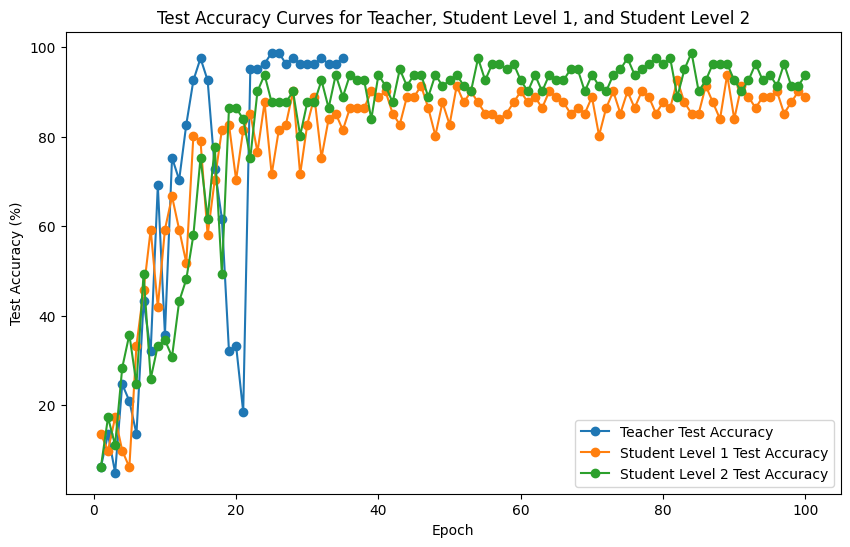

In [1]:
import math
import random
from collections import defaultdict, Counter

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F  # For KL divergence in distillation
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

from Bio import SeqIO
import matplotlib.pyplot as plt  # For plotting

# Set device
device = (
    "cuda" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    "cpu"
)

###################################
# 1. Data Preparation Functions
###################################

def parse_fasta_with_labels(fasta_file):
    data = []
    for record in SeqIO.parse(fasta_file, "fasta"):
        header = record.description.strip()
        sequence = str(record.seq).upper()
        label = header.split()[0]
        data.append((label, sequence))
    return data

def create_train_test_split(raw_data):
    label_to_samples = defaultdict(list)
    for label, seq in raw_data:
        label_to_samples[label].append(seq)
    train_data = []
    test_data = []
    for label, seqs in label_to_samples.items():
        random.shuffle(seqs)
        test_seq = seqs[0]
        train_seqs = seqs[1:]
        test_data.append((label, test_seq))
        for s in train_seqs:
            train_data.append((label, s))
    return train_data, test_data

def generate_kmers(sequence, k=6):
    kmers = []
    for i in range(len(sequence) - k + 1):
        kmers.append(sequence[i:i+k])
    return kmers

def build_kmer_vocab(dataset, k=6):
    kmer_set = set()
    for _, seq in dataset:
        kmers = generate_kmers(seq, k)
        kmer_set.update(kmers)
    vocab = {"<UNK>": 0}
    for i, kmer in enumerate(sorted(kmer_set), start=1):
        vocab[kmer] = i
    return vocab

def encode_sequence(sequence, vocab, k=6):
    kmers = generate_kmers(sequence, k)
    encoded = [vocab.get(kmer, vocab["<UNK>"]) for kmer in kmers]
    return encoded

def filter_classes(raw_data, min_count=5):
    label_counts = Counter([label for (label, _) in raw_data])
    filtered_data = [(label, seq) for (label, seq) in raw_data if label_counts[label] >= min_count]
    return filtered_data

def reverse_complement(seq):
    # For simplicity, we just reverse the sequence.
    return seq[::-1]

def create_paired_data(data_list):
    paired = []
    for label, seq in data_list:
        rev_seq = reverse_complement(seq)
        paired.append((label, seq, rev_seq))
    return paired

class TwoFastaKmerDataset(Dataset):
    """
    Each item: (encoded_seq_fwd, encoded_seq_rev, label_idx)
    """
    def __init__(self, paired_data, vocab, k=6):
        super().__init__()
        self.vocab = vocab
        self.k = k
        labels = sorted(set(item[0] for item in paired_data))
        self.label2idx = {lbl: i for i, lbl in enumerate(labels)}
        self.encoded_data = []
        for label, fwd_seq, rev_seq in paired_data:
            x1 = encode_sequence(fwd_seq, self.vocab, k=self.k)
            x2 = encode_sequence(rev_seq, self.vocab, k=self.k)
            y = self.label2idx[label]
            self.encoded_data.append((x1, x2, y))
    
    def __len__(self):
        return len(self.encoded_data)
    
    def __getitem__(self, idx):
        return self.encoded_data[idx]
    
    def get_vocab_size(self):
        return len(self.vocab)
    
    def get_num_classes(self):
        return len(self.label2idx)

def collate_fn_two(batch):
    seqs_fwd, seqs_rev, labels = zip(*batch)
    seqs_fwd_tensors = [torch.tensor(s, dtype=torch.long) for s in seqs_fwd]
    seqs_rev_tensors = [torch.tensor(s, dtype=torch.long) for s in seqs_rev]
    padded_fwd = pad_sequence(seqs_fwd_tensors, batch_first=True, padding_value=0)
    padded_rev = pad_sequence(seqs_rev_tensors, batch_first=True, padding_value=0)
    labels_tensors = torch.tensor(labels, dtype=torch.long)
    return padded_fwd, padded_rev, labels_tensors

###################################
# 2. Model Architecture
###################################

class ViTDeepSEAEncoder(nn.Module):
    """
    This module performs:
      1. k-mer embedding.
      2. A DeepSEA-style convolutional block.
      3. Batch normalization on the conv output.
      4. A linear projection to d_model.
      5. Addition of positional embeddings.
      6. Transformer encoding over the tokens.
      7. An extra LayerNorm (final normalization) followed by mean pooling.
    """
    def __init__(
        self,
        vocab_size,
        embed_dim=128,
        d_model=256,  # Output feature dimension
        num_conv_filters=(320, 480, 960),
        conv_kernel_sizes=(8, 8, 8),
        pool_kernel_sizes=(4, 4),
        num_transformer_layers=2,
        nhead=8,
        dropout=0.2,  # Increased dropout for better regularization
        max_seq_len=1000
    ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.deepsea_conv = nn.Sequential(
            nn.Conv1d(in_channels=embed_dim, out_channels=num_conv_filters[0], kernel_size=conv_kernel_sizes[0]),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=pool_kernel_sizes[0]),
            nn.Conv1d(in_channels=num_conv_filters[0], out_channels=num_conv_filters[1], kernel_size=conv_kernel_sizes[1]),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=pool_kernel_sizes[1]),
            nn.Conv1d(in_channels=num_conv_filters[1], out_channels=num_conv_filters[2], kernel_size=conv_kernel_sizes[2]),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        self.bn = nn.BatchNorm1d(num_conv_filters[2])
        self.proj = nn.Linear(num_conv_filters[2], d_model)
        self.max_tokens = 150  # Maximum tokens after conv+pooling
        self.pos_embedding = nn.Parameter(torch.zeros(1, self.max_tokens, d_model))
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_transformer_layers)
        self.final_norm = nn.LayerNorm(d_model)  # Additional normalization
        
    def forward(self, x):
        # x: [B, seq_len]
        x = self.embedding(x)            # [B, seq_len, embed_dim]
        x = x.transpose(1, 2)            # [B, embed_dim, seq_len]
        x = self.deepsea_conv(x)         # [B, num_conv_filters[-1], L_out]
        x = self.bn(x)                   # Batch normalization
        x = x.transpose(1, 2)            # [B, L_out, num_conv_filters[-1]]
        x = self.proj(x)                 # [B, L_out, d_model]
        B, L, _ = x.size()
        pos_embed = self.pos_embedding[:, :L, :]
        x = x + pos_embed
        x = self.transformer_encoder(x)  # [B, L, d_model]
        x = self.final_norm(x)           # Final LayerNorm on transformer output
        x = x.mean(dim=1)                # [B, d_model]
        return x

class TwoViTDeepSEAFusionDNAClassifierWithFC(nn.Module):
    """
    Two-branch model: each branch processes one sequence (forward and reverse).
    Their outputs (each d_model-dimensional) are concatenated and fed to a fully-connected layer.
    """
    def __init__(
        self,
        vocab_size,
        num_classes,
        embed_dim=128,
        d_model=256,
        num_conv_filters=(320, 480, 960),
        conv_kernel_sizes=(8, 8, 8),
        pool_kernel_sizes=(4, 4),
        num_transformer_layers=2,
        nhead=8,
        dropout=0.2,  # Use the same dropout rate here
        max_seq_len=1000
    ):
        super().__init__()
        self.vit_branch1 = ViTDeepSEAEncoder(
            vocab_size=vocab_size,
            embed_dim=embed_dim,
            d_model=d_model,
            num_conv_filters=num_conv_filters,
            conv_kernel_sizes=conv_kernel_sizes,
            pool_kernel_sizes=pool_kernel_sizes,
            num_transformer_layers=num_transformer_layers,
            nhead=nhead,
            dropout=dropout,
            max_seq_len=max_seq_len
        )
        self.vit_branch2 = ViTDeepSEAEncoder(
            vocab_size=vocab_size,
            embed_dim=embed_dim,
            d_model=d_model,
            num_conv_filters=num_conv_filters,
            conv_kernel_sizes=conv_kernel_sizes,
            pool_kernel_sizes=pool_kernel_sizes,
            num_transformer_layers=num_transformer_layers,
            nhead=nhead,
            dropout=dropout,
            max_seq_len=max_seq_len
        )
        self.fc = nn.Linear(2 * d_model, num_classes)
    
    def forward(self, x1, x2):
        f1 = self.vit_branch1(x1)  # [B, d_model]
        f2 = self.vit_branch2(x2)  # [B, d_model]
        fused = torch.cat([f1, f2], dim=1)  # [B, 2*d_model]
        logits = self.fc(fused)             # [B, num_classes]
        return logits

###################################
# 3. Build Vocabulary from the Entire Dataset
###################################
fasta_file = "data2/fungi_ITS_cleaned.fasta"
raw_data = parse_fasta_with_labels(fasta_file)
vocab = build_kmer_vocab(raw_data, k=6)

###################################
# Stage 1: Teacher Training (for genera with >=10 samples)
###################################
teacher_data = filter_classes(raw_data, min_count=10)
teacher_train_data, teacher_test_data = create_train_test_split(teacher_data)
teacher_paired_train = create_paired_data(teacher_train_data)
teacher_paired_test = create_paired_data(teacher_test_data)
teacher_dataset = TwoFastaKmerDataset(teacher_paired_train, vocab, k=6)
teacher_test_dataset = TwoFastaKmerDataset(teacher_paired_test, vocab, k=6)

teacher_train_loader = DataLoader(teacher_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn_two)
teacher_test_loader = DataLoader(teacher_test_dataset, batch_size=8, shuffle=False, collate_fn=collate_fn_two)

num_classes_teacher = teacher_dataset.get_num_classes()
vocab_size = teacher_dataset.get_vocab_size()

teacher_model = TwoViTDeepSEAFusionDNAClassifierWithFC(
    vocab_size=vocab_size,
    num_classes=num_classes_teacher,
    embed_dim=128,
    d_model=256,
    num_conv_filters=(320,480,960),
    conv_kernel_sizes=(8,8,8),
    pool_kernel_sizes=(4,4),
    num_transformer_layers=2,
    nhead=8,
    dropout=0.2,
    max_seq_len=1000
).to(device)

optimizer_teacher = optim.AdamW(teacher_model.parameters(), lr=1e-4, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
scheduler_teacher = optim.lr_scheduler.ReduceLROnPlateau(optimizer_teacher, mode='max', factor=0.5, patience=5, verbose=True)

teacher_epochs = 100
best_teacher_acc = 0.0
best_teacher_state = None
patience = 10
patience_counter = 0

# For plotting
teacher_train_acc_list = []
teacher_test_acc_list = []

print("Starting teacher training (min_count >= 10) with early stopping and LR scheduling...")
for epoch in range(1, teacher_epochs + 1):
    teacher_model.train()
    total_loss = 0.0
    for fwd, rev, labels in teacher_train_loader:
        fwd, rev, labels = fwd.to(device), rev.to(device), labels.to(device)
        optimizer_teacher.zero_grad()
        logits = teacher_model(fwd, rev)
        loss = criterion(logits, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(teacher_model.parameters(), max_norm=1.0)
        optimizer_teacher.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(teacher_train_loader)
    
    # Evaluate training accuracy
    teacher_model.eval()
    train_correct = 0
    train_total = 0
    with torch.no_grad():
        for fwd, rev, labels in teacher_train_loader:
            fwd, rev, labels = fwd.to(device), rev.to(device), labels.to(device)
            preds = torch.argmax(teacher_model(fwd, rev), dim=1)
            train_correct += (preds == labels).sum().item()
            train_total += labels.size(0)
    train_acc = 100.0 * train_correct / train_total
    teacher_train_acc_list.append(train_acc)
    
    # Evaluate test accuracy
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for fwd, rev, labels in teacher_test_loader:
            fwd, rev, labels = fwd.to(device), rev.to(device), labels.to(device)
            preds = torch.argmax(teacher_model(fwd, rev), dim=1)
            test_correct += (preds == labels).sum().item()
            test_total += labels.size(0)
    teacher_test_acc = 100.0 * test_correct / test_total
    teacher_test_acc_list.append(teacher_test_acc)
    
    scheduler_teacher.step(teacher_test_acc)
    
    print(f"[Teacher] Epoch {epoch}/{teacher_epochs} | Loss: {avg_loss:.4f} | Train Acc: {train_acc:.2f}% | Test Acc: {teacher_test_acc:.2f}%")
    
    if teacher_test_acc > best_teacher_acc:
        best_teacher_acc = teacher_test_acc
        best_teacher_state = teacher_model.state_dict()
        patience_counter = 0
    else:
        patience_counter += 1
    
    if patience_counter >= patience:
        print(f"Early stopping triggered at epoch {epoch}.")
        break

teacher_model.load_state_dict(best_teacher_state)
for param in teacher_model.parameters():
    param.requires_grad = False
teacher_model.eval()
print(f"Best Teacher Accuracy: {best_teacher_acc:.2f}%")

###################################
# Stage 2: Student Level 1 Training with Distillation (min_count >= 8)
###################################
# Filter student data: classes with >=8 samples and restrict to teacher classes.
student8_data = filter_classes(raw_data, min_count=8)
teacher_class_set = set(teacher_dataset.label2idx.keys())
student8_data = [(label, seq) for (label, seq) in student8_data if label in teacher_class_set]

student8_train_data, student8_test_data = create_train_test_split(student8_data)
student8_paired_train = create_paired_data(student8_train_data)
student8_paired_test = create_paired_data(student8_test_data)
student8_dataset = TwoFastaKmerDataset(student8_paired_train, vocab, k=6)
student8_test_dataset = TwoFastaKmerDataset(student8_paired_test, vocab, k=6)

student8_train_loader = DataLoader(student8_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn_two)
student8_test_loader = DataLoader(student8_test_dataset, batch_size=8, shuffle=False, collate_fn=collate_fn_two)

num_classes_student8 = student8_dataset.get_num_classes()

student8_model = TwoViTDeepSEAFusionDNAClassifierWithFC(
    vocab_size=vocab_size,
    num_classes=num_classes_student8,
    embed_dim=128,
    d_model=256,
    num_conv_filters=(320,480,960),
    conv_kernel_sizes=(8,8,8),
    pool_kernel_sizes=(4,4),
    num_transformer_layers=2,
    nhead=8,
    dropout=0.2,
    max_seq_len=1000
).to(device)

optimizer_student8 = optim.AdamW(student8_model.parameters(), lr=1e-4, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

# Distillation hyperparameters
temperature = 4.0
alpha = 0.5

def distillation_loss(student_logits, teacher_logits, T):
    return F.kl_div(F.log_softmax(student_logits / T, dim=1),
                    F.softmax(teacher_logits / T, dim=1),
                    reduction="batchmean") * (T * T)

student8_epochs = 100
best_student8_acc = 0.0
best_student8_epoch = 0
student8_train_acc_list = []
student8_test_acc_list = []

print("\nStarting Student Level 1 training (min_count >= 8) with distillation from Teacher...")
for epoch in range(1, student8_epochs + 1):
    student8_model.train()
    total_loss = 0.0
    for fwd, rev, labels in student8_train_loader:
        fwd, rev, labels = fwd.to(device), rev.to(device), labels.to(device)
        optimizer_student8.zero_grad()
        student_logits = student8_model(fwd, rev)
        with torch.no_grad():
            teacher_logits = teacher_model(fwd, rev)
        ce_loss = criterion(student_logits, labels)
        kd_loss = distillation_loss(student_logits, teacher_logits, temperature)
        loss = alpha * kd_loss + (1 - alpha) * ce_loss
        loss.backward()
        torch.nn.utils.clip_grad_norm_(student8_model.parameters(), max_norm=1.0)
        optimizer_student8.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(student8_train_loader)
    
    # Evaluate train accuracy for Student Level 1
    student8_model.eval()
    train_correct = 0
    train_total = 0
    with torch.no_grad():
        for fwd, rev, labels in student8_train_loader:
            fwd, rev, labels = fwd.to(device), rev.to(device), labels.to(device)
            preds = torch.argmax(student8_model(fwd, rev), dim=1)
            train_correct += (preds == labels).sum().item()
            train_total += labels.size(0)
    student8_train_acc = 100.0 * train_correct / train_total
    student8_train_acc_list.append(student8_train_acc)
    
    # Evaluate test accuracy for Student Level 1
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for fwd, rev, labels in student8_test_loader:
            fwd, rev, labels = fwd.to(device), rev.to(device), labels.to(device)
            preds = torch.argmax(student8_model(fwd, rev), dim=1)
            test_correct += (preds == labels).sum().item()
            test_total += labels.size(0)
    student8_test_acc = 100.0 * test_correct / test_total
    student8_test_acc_list.append(student8_test_acc)
    
    if student8_test_acc > best_student8_acc:
        best_student8_acc = student8_test_acc
        best_student8_epoch = epoch
        best_student8_state = student8_model.state_dict()
    
    print(f"[Student Level 1] Epoch {epoch}/{student8_epochs} | Loss: {avg_loss:.4f} | Train Acc: {student8_train_acc:.2f}% | Test Acc: {student8_test_acc:.2f}%")

print(f"\nHighest Student Level 1 Test Accuracy: {best_student8_acc:.2f}% at Epoch {best_student8_epoch}")
student8_model.load_state_dict(best_student8_state)
for param in student8_model.parameters():
    param.requires_grad = False
student8_model.eval()

###################################
# Stage 3: Student Level 2 Training with Distillation (min_count >= 5)
###################################
# Filter student data: classes with >=5 samples and restrict to classes present in Student Level 1.
student5_data = filter_classes(raw_data, min_count=5)
student5_data = [(label, seq) for (label, seq) in student5_data if label in set(student8_dataset.label2idx.keys())]

student5_train_data, student5_test_data = create_train_test_split(student5_data)
student5_paired_train = create_paired_data(student5_train_data)
student5_paired_test = create_paired_data(student5_test_data)
student5_dataset = TwoFastaKmerDataset(student5_paired_train, vocab, k=6)
student5_test_dataset = TwoFastaKmerDataset(student5_paired_test, vocab, k=6)

student5_train_loader = DataLoader(student5_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn_two)
student5_test_loader = DataLoader(student5_test_dataset, batch_size=8, shuffle=False, collate_fn=collate_fn_two)

num_classes_student5 = student5_dataset.get_num_classes()

student5_model = TwoViTDeepSEAFusionDNAClassifierWithFC(
    vocab_size=vocab_size,
    num_classes=num_classes_student5,
    embed_dim=128,
    d_model=256,
    num_conv_filters=(320,480,960),
    conv_kernel_sizes=(8,8,8),
    pool_kernel_sizes=(4,4),
    num_transformer_layers=2,
    nhead=8,
    dropout=0.2,
    max_seq_len=1000
).to(device)

optimizer_student5 = optim.AdamW(student5_model.parameters(), lr=1e-4, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

# Use same distillation hyperparameters:
temperature = 4.0
alpha = 0.5

student5_epochs = 100
best_student5_acc = 0.0
best_student5_epoch = 0
student5_acc_list = []

print("\nStarting Student Level 2 training (min_count >= 5) with distillation from Student Level 1...")
for epoch in range(1, student5_epochs + 1):
    student5_model.train()
    total_loss = 0.0
    for fwd, rev, labels in student5_train_loader:
        fwd, rev, labels = fwd.to(device), rev.to(device), labels.to(device)
        optimizer_student5.zero_grad()
        student5_logits = student5_model(fwd, rev)
        with torch.no_grad():
            teacher5_logits = student8_model(fwd, rev)
        ce_loss = criterion(student5_logits, labels)
        kd_loss = distillation_loss(student5_logits, teacher5_logits, temperature)
        loss = alpha * kd_loss + (1 - alpha) * ce_loss
        loss.backward()
        torch.nn.utils.clip_grad_norm_(student5_model.parameters(), max_norm=1.0)
        optimizer_student5.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(student5_train_loader)
    
    student5_model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for fwd, rev, labels in student5_test_loader:
            fwd, rev, labels = fwd.to(device), rev.to(device), labels.to(device)
            preds = torch.argmax(student5_model(fwd, rev), dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    student5_test_acc = 100.0 * correct / total
    student5_acc_list.append(student5_test_acc)
    
    if student5_test_acc > best_student5_acc:
        best_student5_acc = student5_test_acc
        best_student5_epoch = epoch
    
    print(f"[Student Level 2] Epoch {epoch}/{student5_epochs} | Loss: {avg_loss:.4f} | Test Acc: {student5_test_acc:.2f}%")

print(f"\nHighest Student Level 2 Test Accuracy: {best_student5_acc:.2f}% at Epoch {best_student5_epoch}")

###################################
# Plotting Test Accuracy Curves
###################################
plt.figure(figsize=(10,6))
plt.plot(range(1, len(teacher_test_acc_list)+1), teacher_test_acc_list, label="Teacher Test Accuracy", marker="o")
plt.plot(range(1, len(student8_test_acc_list)+1), student8_test_acc_list, label="Student Level 1 Test Accuracy", marker="o")
plt.plot(range(1, len(student5_acc_list)+1), student5_acc_list, label="Student Level 2 Test Accuracy", marker="o")
plt.xlabel("Epoch")
plt.ylabel("Test Accuracy (%)")
plt.title("Test Accuracy Curves for Teacher, Student Level 1, and Student Level 2")
plt.legend()
plt.show()
